In [6]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
import matplotlib.pyplot as plt
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

2025-10-29 21:33:57.792416: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [42]:
data = yf.download("BTC-USD", start=start, end=end, auto_adjust=False)
print(data.columns)
print(data)


[*********************100%***********************]  1 of 1 completed

MultiIndex([('Adj Close', 'BTC-USD'),
            (    'Close', 'BTC-USD'),
            (     'High', 'BTC-USD'),
            (      'Low', 'BTC-USD'),
            (     'Open', 'BTC-USD'),
            (   'Volume', 'BTC-USD')],
           names=['Price', 'Ticker'])
Price           Adj Close          Close           High            Low  \
Ticker            BTC-USD        BTC-USD        BTC-USD        BTC-USD   
Date                                                                     
2018-01-01   13657.200195   13657.200195   14112.200195   13154.700195   
2018-01-02   14982.099609   14982.099609   15444.599609   13163.599609   
2018-01-03   15201.000000   15201.000000   15572.799805   14844.500000   
2018-01-04   15599.200195   15599.200195   15739.700195   14522.200195   
2018-01-05   17429.500000   17429.500000   17705.199219   15202.799805   
...                   ...            ...            ...            ...   
2025-05-27  108994.640625  108994.640625  110744.210938  107609.554

In [44]:
import numpy as np
import pandas as pd
import yfinance as yf

symbol = "BTC-USD" #"EQTL3.SA"
start = "2018-01-01"
end = "2025-06-01"
window_size = 365
threshold = 0.005  # 0.5% de variação para considerar alta/baixa

# ============================================
# 1. Download e limpeza inicial
# ============================================
data = yf.download(symbol, start=start, end=end, auto_adjust=False)

# Se vier com MultiIndex, pega só o nome do preço (nível 0)
if isinstance(data.columns, pd.MultiIndex):
    data.columns = [col[0] for col in data.columns]

# Agora deve ter colunas simples: ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
data = data[['Open', 'High', 'Low', 'Close', 'Volume']].copy()

# ============================================
# 2. Log-returns e datas
# ============================================
for col in ['Open', 'High', 'Low', 'Close']:
    data[f'{col}_ret'] = np.log((data[col] / data[col].shift(1)).replace(0, np.nan))
data['Volume_ret'] = np.log((data['Volume'] / data['Volume'].shift(1)).replace(0, np.nan))

data['DayOfYear'] = data.index.dayofyear
data['Month'] = data.index.month

# ============================================
# 3. Indicadores técnicos
# ============================================
data['EMA9']   = data['Close'].ewm(span=9, adjust=False).mean()
data['SMA20']  = data['Close'].rolling(window=20).mean()
data['SMA200'] = data['Close'].rolling(window=200).mean()

# RSI
delta = data['Close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
data['RSI'] = 100 - (100 / (1 + rs))

# MACD
ema12 = data['Close'].ewm(span=12, adjust=False).mean()
ema26 = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = ema12 - ema26
data['MACD_signal'] = data['MACD'].ewm(span=9, adjust=False).mean()

# Momentum (30 dias)
data['Momentum'] = np.log(data['Close'] / data['Close'].shift(30))

# ============================================
# 4. Relações relativas e codificação temporal
# ============================================
data['Close_div_EMA9']   = data['Close'] / data['EMA9'] - 1
data['Close_div_SMA20']  = data['Close'] / data['SMA20'] - 1
data['Close_div_SMA200'] = data['Close'] / data['SMA200'] - 1

data['sin_day'] = np.sin(2 * np.pi * data['DayOfYear'] / 365)
data['cos_day'] = np.cos(2 * np.pi * data['DayOfYear'] / 365)

# Normalização de MACD por volatilidade (rolling std)
rolling_std = data['Close_ret'].rolling(window=60).std()
data['MACD_norm'] = (data['MACD'] - data['MACD'].rolling(60).mean()) / (rolling_std + 1e-8)
data['MACD_signal_norm'] = (data['MACD_signal'] - data['MACD_signal'].rolling(60).mean()) / (rolling_std + 1e-8)

# ============================================
# 5. Limpeza final
# ============================================
data = data.dropna()

# ============================================
# 6. Features finais e normalização
# ============================================
final_features = [
    'Open_ret','High_ret','Low_ret','Close_ret','Volume_ret',
    'Close_div_EMA9','Close_div_SMA20','Close_div_SMA200',
    'RSI','Momentum','sin_day','cos_day','MACD_norm','MACD_signal_norm'
]

def rolling_normalize(X_window):
    mu = X_window.mean(axis=0)
    sigma = X_window.std(axis=0) + 1e-8
    return (X_window - mu) / sigma

# ============================================
# 7. Construção das janelas (X, y)
# ============================================
X, y, window_dates = [], [], []
data_values = data[final_features].values
open_prices = data['Open'].values
close_prices = data['Close'].values


for i in range(window_size, len(data_values) - 1):
    window = data_values[i - window_size:i]
    window = rolling_normalize(window)
    X.append(window)
    
    # Retorno futuro
    future_ret = (close_prices[i + 1] - open_prices[i + 1]) / open_prices[i + 1]
    if future_ret > threshold:
        label = 1
    elif future_ret < -threshold:
        label = 0
    
    y.append(label)
    window_dates.append(data.index[i])

# ============================================
# 8. Converter para numpy
# ============================================
X = np.array(X)
y = np.array(y)
window_dates = np.array(window_dates)

print("Formato de X:", X.shape)
print("Formato de y:", y.shape)
print("Classes:", np.unique(y, return_counts=True))
print("Primeiras datas:", window_dates[:3])


[*********************100%***********************]  1 of 1 completed


Formato de X: (2143, 365, 14)
Formato de y: (2143,)
Classes: (array([0, 1]), array([1045, 1098]))
Primeiras datas: [Timestamp('2019-07-19 00:00:00') Timestamp('2019-07-20 00:00:00')
 Timestamp('2019-07-21 00:00:00')]


[ 2.15277786  2.16352441  2.15150527  2.08917205 -0.96019069  2.12038684
  2.10813706  1.46128205 -0.00564164  1.34480743 -0.29127731]


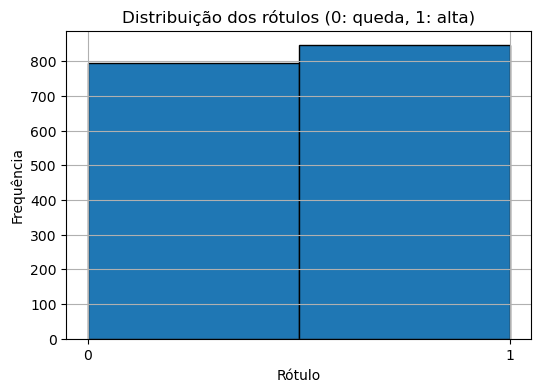

In [41]:
# Normalização dos dados
"""
n_samples, n_timesteps, n_features = X.shape
X_reshaped = X.reshape(-1, n_features)  # Achata para aplicar a normalização
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reshaped)
X = X_scaled.reshape(n_samples, n_timesteps, n_features)

# Visualizando a distribuição dos rótulos
plt.figure(figsize=(6,4))
plt.hist(y, bins=2, edgecolor='k', align='mid')
plt.xticks([0, 1])
plt.title("Distribuição dos rótulos (0: queda, 1: alta)")
plt.xlabel("Rótulo")
plt.ylabel("Frequência")
plt.grid(True)
#plt.show()
print(X[-1][-1])  # primeira janela, primeira linha
"""

In [46]:
# Dividindo os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
n_features = len(final_features)
print(len(X_train[0]))
print(y_train[0])

365
1


In [ ]:

# 4. Construção do modelo CNN 1D para múltiplas features

from tensorflow.keras.layers import Dropout

model = Sequential([
    LSTM(128, return_sequences=True),
    BatchNormalization(),
    LSTM(64),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])


# Compilando o modelo
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# 5. Treinamento do modelo
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_split=0.2)

# Plot do histórico de treinamento
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title("Histórico de Loss")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title("Histórico de Acurácia")
plt.xlabel("Época")
plt.ylabel("Acurácia")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 6. Avaliação do modelo no conjunto de teste
loss, acc = model.evaluate(X_test, y_test)
print("Acurácia no conjunto de teste:", acc)

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.8,       # redução suave
    patience=20,      # espera mais antes de reduzir LR
    min_lr=1e-7,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

callbacks = [reduce_lr, checkpoint]

# --- Treinamento ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=1,         # treino longo
    batch_size=64,       # acelera e suaviza treino
    callbacks=callbacks,
    verbose=2            # menos poluição no log
)

In [22]:
# Após o treinamento, para obter as probabilidades no conjunto de teste:
predicted_probabilities = model.predict(X_test)

# Exibir as probabilidades para os 5 primeiros exemplos:
for i, prob in enumerate(predicted_probabilities[:5]):
    print(f"Amostra {i}: Probabilidade de alta = {prob[0]:.2f}")
    
# Caso você queira converter para um sinal (subir/descender) utilizando um threshold de 0.5:
predicted_signals = (predicted_probabilities.flatten() > 0.5).astype(int)
print("Sinais previstos (0: baixa, 1: alta) para os 5 primeiros exemplos:", predicted_signals[:5])


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Amostra 0: Probabilidade de alta = 0.52
Amostra 1: Probabilidade de alta = 0.99
Amostra 2: Probabilidade de alta = 1.00
Amostra 3: Probabilidade de alta = 0.76
Amostra 4: Probabilidade de alta = 0.60
Sinais previstos (0: baixa, 1: alta) para os 5 primeiros exemplos: [1 1 1 1 1]


In [104]:
model.save("modelo_completo.keras")


In [26]:
model.summary()
loss, acc = model.evaluate(X_test, y_test)
print("Acurácia no conjunto de teste:", acc)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 58, 32)         │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 58, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,941 (296.65 KB)

 Trainable params: 25,313 (98.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 50,628 (197.77 KB)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4810 - loss: 1.6227
Acurácia no conjunto de teste: 0.4810126721858978


In [108]:
# from tensorflow.keras.utils import plot_model

# plot_model(model, to_file='modelo.png', show_shapes=True, show_layer_names=True)
